In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [9]:
# Định nghĩa mã cổ phiếu và khoảng thời gian lấy dữ liệu
ma_cophieu = "BSI.VN"
khoang_thoi_gian = "60d"  # Lấy dữ liệu trong 60 ngày gần nhất
buoc_thoi_gian = "2m"     # Khoảng thời gian 5 phút

# Tải dữ liệu từ Yahoo Finance
data = yf.download(ma_cophieu, period=khoang_thoi_gian, interval=buoc_thoi_gian)

# Kiểm tra dữ liệu
# print(data.head())
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BSI.VN,BSI.VN,BSI.VN,BSI.VN,BSI.VN
Datetime,,,,,
2025-02-24 02:14:00+00:00,46450.0,46700.0,46450.0,46700.0,0
2025-02-24 02:18:00+00:00,46450.0,46450.0,46450.0,46450.0,1000
2025-02-24 02:20:00+00:00,46400.0,46400.0,46400.0,46400.0,400
2025-02-24 02:22:00+00:00,46550.0,46550.0,46400.0,46400.0,11600
2025-02-24 02:24:00+00:00,46950.0,46950.0,46550.0,46550.0,51000
...,...,...,...,...,...
2025-04-09 07:20:00+00:00,46250.0,46250.0,46250.0,46250.0,26400
2025-04-09 07:22:00+00:00,46250.0,46250.0,46250.0,46250.0,19200


In [10]:
# Lựa chọn cột giá đóng cửa và loại bỏ các giá trị NaN
data = data[['Close']].dropna()

# Chuẩn hóa dữ liệu về khoảng [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Chia dữ liệu thành tập huấn luyện và kiểm tra (80% huấn luyện, 20% kiểm tra)
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Hàm tạo tập dữ liệu theo định dạng phù hợp cho LSTM
def create_dataset(dataset, time_step=50):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Tạo tập huấn luyện và kiểm tra
time_step = 50  # Sử dụng 30 khoảng thời gian trước đó để dự đoán
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape dữ liệu để phù hợp với đầu vào của LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [11]:
# Khởi tạo mô hình LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.3),
    LSTM(units=50, return_sequences=True),
    Dropout(0.3),
    LSTM(units=50),
    Dropout(0.3),
    Dense(units=1)
])

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Thiết lập hàm dừng sớm để tránh overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1411 - val_loss: 0.0037
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0093 - val_loss: 0.0021
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0079 - val_loss: 0.0014
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0072 - val_loss: 0.0013
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0068 - val_loss: 0.0019
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0063 - val_loss: 0.0015
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0057 - val_loss: 0.0013
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0054 - val_loss: 0.0013
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0058 - val_loss: 0.0026
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 12/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


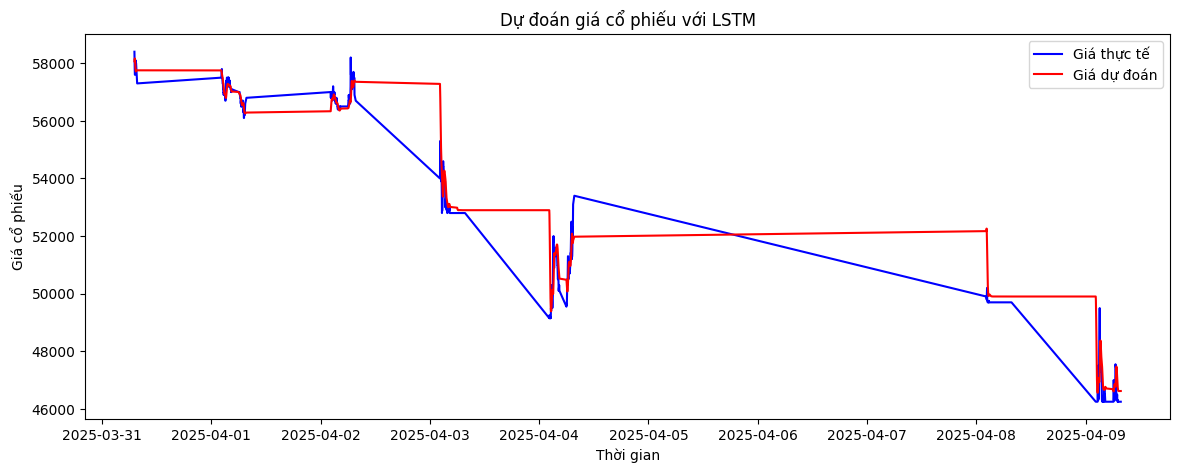

RMSE: 667.0022362120867
MAE: 402.76114783653844
MAPE: 0.7974874003167565%


In [12]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đưa dữ liệu dự đoán và thực tế về giá trị gốc
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Vẽ biểu đồ so sánh giá thực tế và giá dự đoán
plt.figure(figsize=(14, 5))
plt.plot(data.index[train_size + time_step:], y_test_inv, color='blue', label='Giá thực tế')
plt.plot(data.index[train_size + time_step:], y_pred_inv, color='red', label='Giá dự đoán')
plt.title('Dự đoán giá cổ phiếu với LSTM')
plt.xlabel('Thời gian')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.show()



# y_pred = model.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred)
# y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính các metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")


In [13]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# --- HỒI QUY ---
# Tính các metrics hồi quy
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print("----- HỒI QUY -----")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# --- PHÂN LOẠI (TĂNG / GIẢM) ---
# Chuyển y_test và y_pred về nhãn nhị phân: 1 nếu tăng, 0 nếu giảm
y_test_label = (y_test_inv[1:] > y_test_inv[:-1]).astype(int).flatten()
y_pred_label = (y_pred_inv[1:] > y_pred_inv[:-1]).astype(int).flatten()

# Cắt cho khớp độ dài
min_len = min(len(y_test_label), len(y_pred_label))
y_test_label = y_test_label[:min_len]
y_pred_label = y_pred_label[:min_len]

# Tính các chỉ số phân loại
acc = accuracy_score(y_test_label, y_pred_label)
prec = precision_score(y_test_label, y_pred_label, zero_division=0)
rec = recall_score(y_test_label, y_pred_label, zero_division=0)
f1 = f1_score(y_test_label, y_pred_label, zero_division=0)

print("\n----- PHÂN LOẠI (TĂNG/GIẢM) -----")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")


----- HỒI QUY -----
RMSE: 667.0022
MAE:  402.7611
MAPE: 0.80%

----- PHÂN LOẠI (TĂNG/GIẢM) -----
Accuracy:  0.5886
Precision: 0.2698
Recall:    0.3452
F1-score:  0.3029
